In [1]:
# This Jupyter notebook was created by Emily Olafson to predicit cognitive scores from structural and functional connectivity data in stroke subjects.
# Last updated: February 7 2022
# https://github.com/emilyolafson/cognition_nemo

#import relevant libraries
import sys; sys.path
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime
import pickle 
from sklearn.pipeline import Pipeline
import scipy.io as sio
from scipy.stats import spearmanr, pearsonr
from joblib import parallel_backend, Parallel, delayed
from sklearn import preprocessing, linear_model
from sklearn.metrics import explained_variance_score, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.utils.fixes import loguniform
import matplotlib as mpl
from numpy import genfromtxt
import nibabel as nib
import os

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    FROM: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def prepare_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    zeros=X==0
    zeros=np.sum(zeros,0)
    zeros=zeros==X.shape[0]
    X=X[:,~zeros]
    print("Final size of X: " + str(X.shape))
    
    return X

def prepare_image_data(X):
    '''Clean X-data (remove zero-value input variables)'''

    # remove inputs that are 0 for all subjects
    X=np.reshape(X, (101,902629))
    print("Final size of X: " + str(X.shape))
    
    return X

def np_pearson_cor(x, y):
    '''Fast array-based pearson correlation that is more efficient. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    xv = x - x.mean(axis=0)
    yv = y - y.mean(axis=0)
    xvss = (xv * xv).sum(axis=0)
    yvss = (yv * yv).sum(axis=0)
    result = np.matmul(xv.transpose(), yv) / np.sqrt(np.outer(xvss, yvss))
    
    # bound the values to -1 to 1 in the event of precision issues
    return np.maximum(np.minimum(result, 1.0), -1.0)


def naive_pearson_cor(X, Y):
    '''Naive (scipy-based/iterative) pearson correlation. 
    FROM: https://cancerdatascience.org/blog/posts/pearson-correlation/.
        x - input N x p
        y - output N x 1
        
        returns correlation p x 1 '''
    result = np.zeros(shape=(X.shape[1], Y.shape[1]))
    for i in range(X.shape[1]):
        for j in range(Y.shape[1]):
            r, _ = pearsonr(X[:,i], Y[:,j])
            result[i,j] = r
    return result[0]


def feature_select_PCA(x_train, x_test, a):
    """Return values for the top a PCs of x based on PCA of x.
         
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of PCs
         
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features 
            var_expl = variance explained by top a components
            components = PCs selected"""
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
    
    # Feature selection: use only the top n features based on top a PCs in training data 
    pca = PCA(n_components=a, copy=True, random_state=42)
    x_train_featselect = pca.fit(x_train).transform(x_train)
    x_test_featselect = pca.transform(x_test)
    components = pca.components_

    
    var_expl = pca.explained_variance_


    return x_train_featselect,x_test_featselect, components

def feature_select_correlation(x_train, x_test, y, a):
    """Return values for the top a features of x based on abs. value Spearman correlation with y.
         Inputs:
             x = input matrix
             y = variable/s predicted 
             a = number of features to retain
        
        Returns:
            x_train_featselect = training data with selected features 
            x_test_featselect = test data matrix with selected features
            ind = indices of top a features """
    
    # check that dimension of x is greater than a
    if x_train.shape[1]<a:
        raise Exception('Number of features in X is less than the number of features specified to retain (a).') 
        
        
    # Feature selection: use only the top n features based on correlation of training features with y
    correl = abs(np_pearson_cor(x_train, y))
    ind = np.argpartition(correl, -a, 0)[-a:] # select top a features

    # return training/test data with only top features
    x_train_featselect=np.squeeze(x_train[:,ind],2)
    
    x_test_featselect=np.squeeze(x_test[:,ind],2)

    return x_train_featselect,x_test_featselect, ind


def scale_data(x_train, x_test):
    '''Scale the training data and apply transformation to the test/validation data.

        Inputs:
            x_train = training predictors
            x_test = training predictors 
        
        Returns:
            x_train_scaled
            x_test_scaled '''
    
    # Scale x_train 
    scaler = preprocessing.StandardScaler().fit(x_train)
    
    # apply transformation to train & test set.
    x_train_scaled = scaler.transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    return x_train_scaled, x_test_scaled


def gcv_ridge(hyperparam, x, y, k, featsel='None', a=10):
    """Perform gridsearch using k-fold cross-validation on a single hyperparameter 
    in ridge regression, and return mean R^2 across inner folds.
    
    Inputs: 
        hyperparam = list of hyperparameter values to train & test on validation est
        x = N x p input matrix
        y = 1 x p variable to predict
        k = k value in k-fold cross validation 
        featsel = type string, feature selection method, default="None"
            'None' - no feature selection; use all variables for prediction
            'correlation'- calculate the abs. val. Pearson correlation between all training variables with the varibale to predict. Use the highest 'a' variables based on their correlation for prediction
            'PCA' - perform PCA on the training variables and use the top 'a' PCs as input variables, by variance explained, for prediction
        a = number of features to select using one of the above methods, default=10 
    
    Returns:
        r2 = the mean R^2 (coefficient of determination) across inner loop folds for the given hyperparameter
    """
    
    # make sure k is reasonable 
    if x.shape[0]/k <= 2:
        raise Exception('R^2 is not well-defined with less than 2 subjects.')   
    
    # set alpha in ridge regression
    alpha = hyperparam
    # Initialize lists with final results
    y_pred_total = []
    y_valid_total = []
    R2 = []
    comp = []
    correl=[]
    explvar=[]
    # Split data into test and train: random state fixed for reproducibility
    kf = KFold(n_splits=k,shuffle=True,random_state=43)
    
    # K-fold cross-validation 
    for train_index, valid_index in kf.split(x):
        x_train, x_valid = x[train_index], x[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        x_train, x_valid = scale_data(x_train, x_valid)
        
        if featsel=='correlation':
            x_train, x_valid, ind = feature_select_correlation(x_train, x_valid, y_train, a)
            comp.append(ind)
            
        elif featsel=='PCA':
            x_train, x_valid, components = feature_select_PCA(x_train, x_valid, a)
            comp.append(components)
        elif featsel=='none':
            x_train=x_train
            x_valid=x_valid
        
        # Fit ridge regression with (x_train_scaled, y_train), and predict x_train_scaled
        regr = linear_model.Ridge(alpha=alpha, normalize=True, max_iter=1000000, random_state=42)
        y_pred = regr.fit(x_train, y_train).predict(x_valid)

        R2.append(r2_score(y_valid, y_pred))
        correlation=np_pearson_cor(y_pred, y_valid)[0]
        correl.append(correlation)
        explvar.append(explained_variance_score(y_valid, y_pred))
        
        # Append y_pred and y_valid values of this k-fold step to list with total values
        y_pred_total.append(y_pred)
        y_valid_total.append(y_valid)

    r2=np.mean(R2)
    cor=np.mean(correl)
    expl_var=np.mean(explvar)
    return expl_var

def parallel_featsearch(alpha, X, Y, k, featselect, feat):
    expl_var=gcv_ridge(alpha, X, Y, k, featselect, feat)
    return expl_var

# Inner loop - grid search
def gridsearch_cv(k, x, y, featselect, alphas, feats):
    ''' Performs grid search using fixed predefined hyperparameter ranges and returns the best alpha and # of features for 
        a given training/validation sample. 
        
        Returns:
            bestalpha - optimal alpha based on grid search
            bestfeats - optimal number of features based on grid search
            bestr2 - mean R^2 across folds obtained for the optimal combination of hyperparameters'''
    
    print(str(k)+"-fold cross-validation results in "+str((x.shape[0]/k)*(k-1))+ " subjects in the training set, and "+ str(x.shape[0]/k) + " subjects in the validation set")

    # initialize array to store r2
    gcv_values=np.empty(shape=(len(alphas),len(feats)),dtype='float')

    # iterate through alphas
    for alpha in alphas:
        row, = np.where(alphas==alpha)
        
        if featselect == 'none':
            # run feature selection (# of components) in parallel
            gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch)(alpha,x, y, k, featselect, 0))
            gcv=np.array(gcv)
            gcv_values[row]=gcv
        else:
           # run feature selection (# of components) in parallel
            gcv=Parallel(n_jobs=-1,verbose=0)(delayed(parallel_featsearch)(alpha,x, y, k, featselect, feat) for feat in feats)
            gcv=np.array(gcv)
            gcv_values[row]=gcv

            
        row=np.argmax(np.max(gcv_values, axis=1))
        col=np.argmax(np.max(gcv_values, axis=0))

    bestalpha=alphas[row]
    bestfeats=feats[col]
    bestr2=np.max(gcv_values)

    return bestalpha, bestfeats, bestr2, gcv_values

def gridsearch_plsr(k, x, y, components):
    
    # initialize array to store r2
    gcv_values=np.empty(shape=(len(components)),dtype='float')
    
    presssum=[]
    # iterate through components
    for comp in components:
        
        row, = np.where(components==comp)
        
        kf = KFold(n_splits=k,shuffle=True,random_state=43)
        
        scores=[]
        press=[]
        
        # calculate PRESS for each held-out subject
        for i in range(0, x.shape[0]):
            trainx = np.delete(x, i, axis=0)
            trainy = np.delete(y, i, axis=0)
            
            pls = PLSRegression(n_components=comp, scale=True, copy=False)
            pls.fit(trainx, trainy)

            ypred = pls.predict(x[i,:].reshape(1, -1) )
            ytrue=y[i].reshape(1, -1)
            #plt.subplot(1,2,1)
            #plt.imshow(ytrue.T)
            #plt.subplot(1,2,2)
            #plt.imshow(ypred.T)
            #plt.show()
            press.append(sum((ytrue.T-ypred.T)**2))
            
        presssum.append(np.sum(press))
        
    return presssum

def plot_figure(gcv_values, string, midpt):
    '''Plots the R^2 value obtained across all grid-search pairs (# features and regularization values.)'''
    
    plt.figure(figsize=(17,14))
    shifted_cmap = shiftedColorMap(plt.get_cmap('bwr'), midpoint=0.96, name='shifted')

    plt.imshow(gcv_values, cmap=shifted_cmap, interpolation='nearest')

    plt.xlabel('# Features', fontsize=15, fontweight='bold')
    plt.ylabel('Alphas', fontsize=15, fontweight='bold')

    row=np.argmax(np.max(gcv_values, axis=0))
    col=np.argmax(np.max(gcv_values, axis=1))

    ax = plt.axes()

    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(1))

    xticks= np.linspace(feat_start, feat_end,n_feats, dtype=int)
    yticks= np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    plt.xticks(np.arange(len(feats)), fontsize=18)
    plt.yticks(np.arange(len(alphas)), fontsize=18)

    ax.set_xticklabels(xticks)
    ax.set_yticklabels(np.round(yticks,3))

    #ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{xticks: .2f}'))
    cbar = plt.colorbar()
    cbar.set_label('R^2')
    plt.title(string + '_Best R^2 = ' + str(np.round(np.max(gcv_values), 3)), fontsize=20)

    plt.scatter(row,col,color='k')
    plt.savefig(results_dir+string+ '.png')
    plt.show()




In [3]:
# ------- Load data -----------

# Set paths
data_dir='/home/ubuntu/cognition_iowa/'
results_dir='/home/ubuntu/cognition_iowa/results/' 

#Load input variables (estimated SC and FC) and save all subjects to one .mat file for eFC prediction (Zijin's code)
nROIs=86
subj_id =  pd.read_csv(data_dir + 'final_subIDs.csv',header=None)[0]
sc = np.zeros([len(subj_id),3655])
sc_n = np.zeros([len(subj_id),86])

# Load SC
for i in range(len(subj_id)):
    filename = data_dir + "data/sc/%s_nemo_output_chacoconn_fs86subj_nemoSC_volnorm.txt" % (subj_id[i])
    sc_tmp = np.genfromtxt(filename, delimiter='')
    # node strength
    sc_node=np.copy(sc_tmp)
    # first remove negative entries
    sc_node[sc_node < 0]=np.nan
    # take sum across rows
    sc_node=np.nansum(sc_node,axis=1)
    sc_n[i,:]=sc_node
    
    # pairwise vectorized upper triangular
    np.fill_diagonal(sc_tmp, 0)
    sc[i,:] = sc_tmp[np.triu_indices(nROIs,k=1)]
    
sio.savemat(data_dir + 'allstroke_SCs.mat', {'sc':sc}) # used to predict eFC using Zijin's code.

# Load SC - for all subjects
allsubjects =  pd.read_csv('/home/ubuntu/cognition_iowa/allsubjects.csv',header=None)[0]
scall = np.zeros([len(subj_id),3655])

# Load FC
fc = np.zeros([len(subj_id),3655])
fc_n = np.zeros([len(subj_id),86])

#for i in range(len(subj_id)):
#    filename = data_dir + "data/fc/%s_FC.txt" % (subj_id[i])
#    fc_tmp = np.genfromtxt(filename, delimiter='')
#    
    # node strength
#    fc_node=np.copy(fc_tmp)
    # first remove negative entries
#    fc_node[fc_node < 0]=np.nan
    # take sum across rows
#    fc_node=np.nansum(fc_node,axis=1)
#    fc_n[i,:]=fc_node
    
#    # pairwise vectorized upper triangular
#    np.fill_diagonal(fc_tmp, 0)
#    fc[i,:] = fc_tmp[np.triu_indices(nROIs,k=1)]
    
# Load lesion volume
lesionvol = np.zeros([len(subj_id),1])

#for i in range(len(subj_id)):
#    filename = data_dir + "lesionvol/%s.txt" % (subj_id[i])
#    tmp= np.genfromtxt(filename, delimiter='')
#    lesionvol[i,:] =tmp[0]
#lesionvol=np.log(lesionvol) # log-transform lesion data

# Load lesion
#image = np.zeros([len(subj_id),91,109,91])
#for i in range(len(subj_id)):
#    filename = os.path.join(data_dir,  "lesion/%s_2mm.nii.gz" % (subj_id[i]))
#    tmp= nib.load(filename).get_fdata()
#    image[i,:,:,:]=tmp
        
# Load demographic variables and outcome measures (TMT and WAIS)
#read in demographic info at first time point
demo =  pd.read_csv(data_dir + 'demographic_final.csv',header=0)



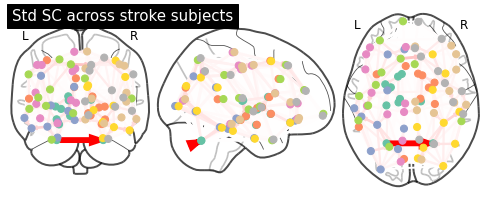

In [11]:
# SC average across stroke subjects
from nilearn import datasets
from nilearn import plotting

fs86 = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86[inds] = np.mean(sc, axis=0)

coordinates = plotting.find_parcellation_cut_coords('fs86_allsubj_mode.nii.gz')
plotting.plot_connectome(fs86, coordinates,
                         title='Mean SC across stroke subjects')


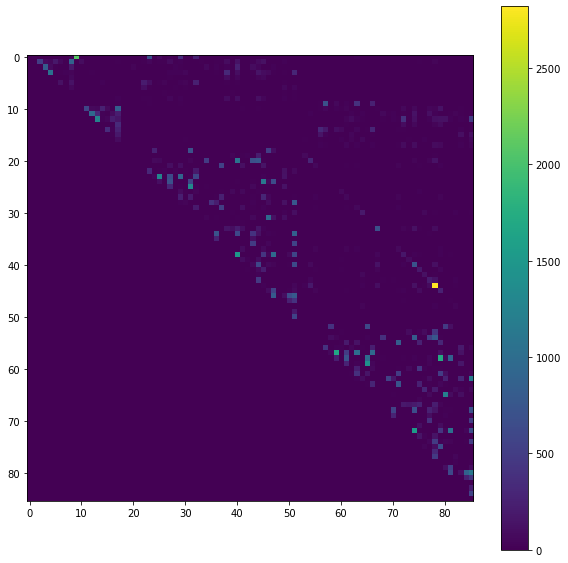

In [10]:
plt.figure(figsize=(10,10))
fs86_vec=fs86[np.triu_indices(nROIs,k=1)]
plt.imshow(fs86)
plt.colorbar()

(array([3.628e+03, 2.500e+01, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([    0.        ,  5302.21554763, 10604.43109527, 15906.6466429 ,
        21208.86219054, 26511.07773817, 31813.29328581, 37115.50883344,
        42417.72438108, 47719.93992871, 53022.15547635]),
 <BarContainer object of 10 artists>)

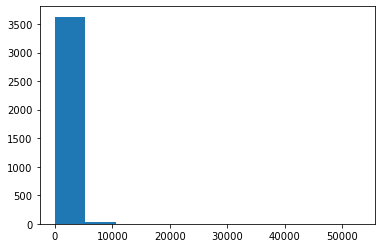

In [9]:
plt.hist(fs86_vec)

In [75]:
# -------------------- MODEL OPTIMIZATION --------------------
# range of alphas
n_alphas=20
alpha_start=-3
alpha_end=3
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10,dtype=None)

#number of features (# pricipal components or variables to retain)
feat_start=1
feat_end=30

n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

#set the proportion of data you want in your training set
train_size = .8

#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#X=np.concatenate([sc, fc], axis=1)
X=sc
X=prepare_data(X)

#set y to be the measure you want to predict
#Y = np.log(np.array(tmt))
Y=np.array(pc1)

# set aside data for hold-out final testing: 
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=4)

# feature selection type
featselect='PCA'

bestalpha, bestfeats, bestr2, gcv_values_r2= gridsearch_cv(k, x, y, featselect, alphas, feats)

row=np.argmax(np.max(gcv_values_r2, axis=1))
col=np.argmax(np.max(gcv_values_r2, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values_r2), 3)))


Final size of X: (79, 3192)
5-fold cross-validation results in 50.4 subjects in the training set, and 12.6 subjects in the validation set
Best combination: 
 alpha =  12.742749857031322 
 Features =  7 
 R^2 =  0.007


<ipython-input-50-bf1bc252c8ef>:356: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


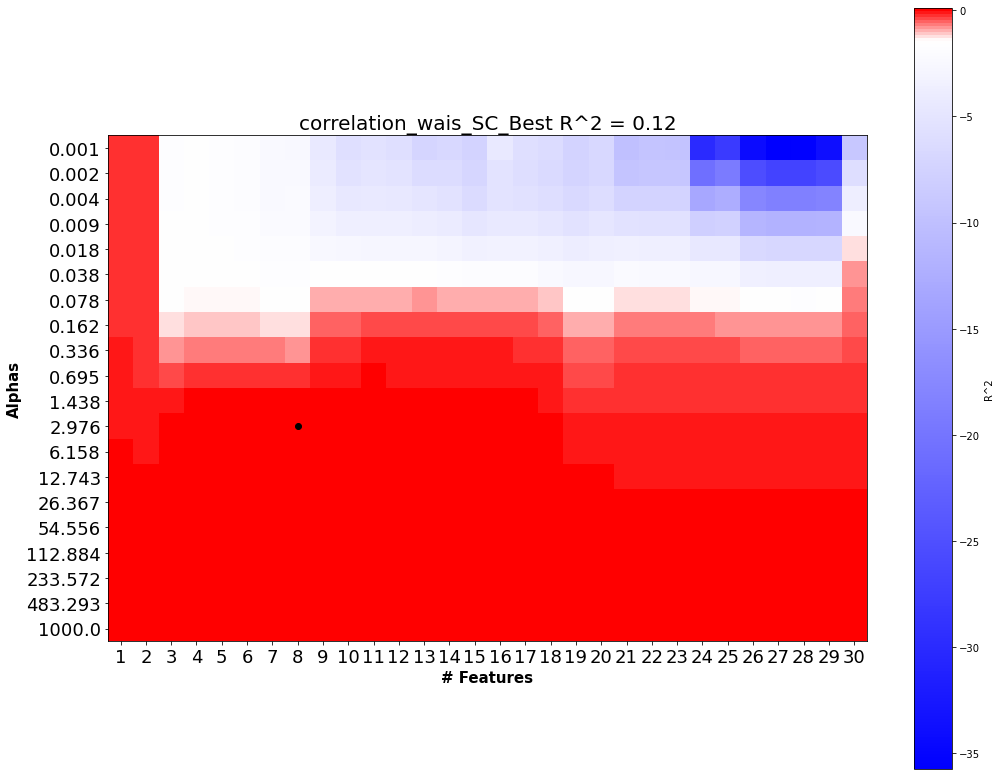

In [73]:
# plot variance explained over hyperparameter search space
plot_figure(gcv_values_r2,'correlation_wais_SC', 0.999)

In [76]:
# predictions for SC-  PCA and correlation

import datetime

# feature selection type
f=['PCA']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #set x data to be the input variable you want to use
    #ie fc, sc, or hc
    #X=np.concatenate([sc, fc], axis=1)
    X=sc
    X=prepare_data(X)

    #set y to be the measure you want to predict
    Y = np.array(pc1)
    
    # range of alphas
    n_alphas=20
    alpha_start=-3
    alpha_end=3
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=1
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    correlations=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        cor=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)
            print('inner loop best r2', str(bestr2))
            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)

            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))
            cor.append(np_pearson_cor(Y[test], y_pred))
            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        correlations.append(cor)
        
        print("Permutation avg. explained variance: " + str(np.mean(expl_var)))
        print(impt[0].shape)
        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()
        
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_correlations.pkl', 'wb')
        pickle.dump(correlations, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
     
        output = open(results_dir + featselect + 'p' + str(p) + '_SC_varimpt.pkl', 'wb')
        pickle.dump(importance, output)
        output.close()   


Final size of X: (79, 3192)
Permutation: 0
5-fold cross-validation results in 50.4 subjects in the training set, and 12.6 subjects in the validation set
inner loop best r2 -0.00017943028482092505
time to run loop: 0:00:09.097023
Explained var: -5.537482730222365e-05
correlation: [[-0.17668029]]
5-fold cross-validation results in 50.4 subjects in the training set, and 12.6 subjects in the validation set
inner loop best r2 0.12878031498110862
time to run loop: 0:00:09.315639
Explained var: -0.09975024783985842
correlation: [[-0.13659377]]
5-fold cross-validation results in 50.4 subjects in the training set, and 12.6 subjects in the validation set
inner loop best r2 0.03862676451323062
time to run loop: 0:00:09.141061
Explained var: -0.008495619448596337
correlation: [[-0.17132246]]
5-fold cross-validation results in 50.4 subjects in the training set, and 12.6 subjects in the validation set
inner loop best r2 0.04363856441953935
time to run loop: 0:00:09.233799
Explained var: -0.002105465

KeyboardInterrupt: 

(array([1., 2., 2., 0., 3., 1., 4., 5., 3., 4.]),
 array([-5.51850454e+00, -4.82915769e+00, -4.13981084e+00, -3.45046399e+00,
        -2.76111713e+00, -2.07177028e+00, -1.38242343e+00, -6.93076582e-01,
        -3.72973172e-03,  6.85617119e-01,  1.37496397e+00]),
 <BarContainer object of 10 artists>)

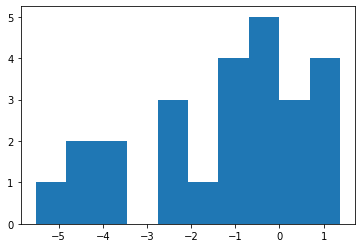

In [70]:
plt.hist(np.log(pc1))

In [216]:
# -------- assessing model weights and features selected -----------

shape=[]
alldice=[]
alldicestd=[]
allalldice=[]
numfeatures=[]
countweights=np.zeros(shape=(3192, 1), dtype='int')
for p in range(0,100):
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features_rangefeat.pkl', 'rb') as f:
        feats = pickle.load(f)
        
    # calculate the dice coefficient
    dice=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one=feats[x]
            two= feats[y]
            test=np.intersect1d(one,two)
            dice[x,y]=2*(test.shape[0]/(one.shape[0]+two.shape[0]))
    
    for x in range(0,5):
        numfeatures.append(feats[x].shape[0])
        
    dice=dice[np.triu_indices(5,k=1)] # only calcualting mean/std across 10 unique comparisons
    allalldice.append(dice)
    alldice.append(np.mean(dice))
    alldicestd.append(np.std(dice))
    
    # count how many times a feature shows up? max 5 per thing.
    for k in range(0, 3192):
        for x in range(0,5):
            if np.isin(k, feats[x]):
                countweights[k] = countweights[k] +1
                


Text(0, 0.5, 'Count')

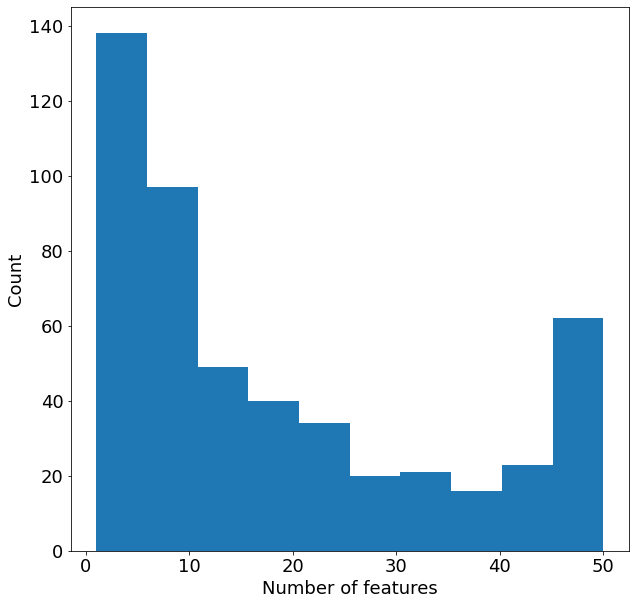

In [94]:
plt.figure(figsize=(10,10))
plt.hist(numfeatures)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of features', fontsize=18)
plt.ylabel('Count',fontsize=18)

In [214]:
alldice_null=[]
alldice_nullstd=[]
allalldice_null=[]
for k in range(0,100):
    # calculate the dice coefficient for randomly selected features
    dice_null=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one = np.random.randint(0,3192, size=(1,30))
            two =  np.random.randint(0,3192, size=(1,30))
            test=np.intersect1d(one,two)
            dice_null[x,y]=2*(test.shape[0]/(one.shape[1]+two.shape[1]))
     
    alldice_null.append(np.mean(dice_null))
    alldice_nullstd.append(np.std(dice_null))
    allalldice_null.append(dice_null)

alldice_null2=[]
alldice_nullstd2=[]
allalldice_null2=[]
for k in range(0,100):
    # calculate the dice coefficient for randomly selected features
    dice_null2=np.zeros(shape=(5,5),dtype='float')
    for x in range(0,5):
        for y in range(0,5):
            if x==y :
                continue
            one = np.random.randint(0,3192, size=(1,15))
            two =  np.random.randint(0,3192, size=(1,15))
            test=np.intersect1d(one,two)
            dice_null2[x,y]=2*(test.shape[0]/(one.shape[1]+two.shape[1]))
     
    alldice_null2.append(np.mean(dice_null2))
    alldice_nullstd2.append(np.std(dice_null2))
    allalldice_null2.append(dice_null2)


Text(0.5, 1.0, 'Proportion of outer folds including weight (x-axis)')

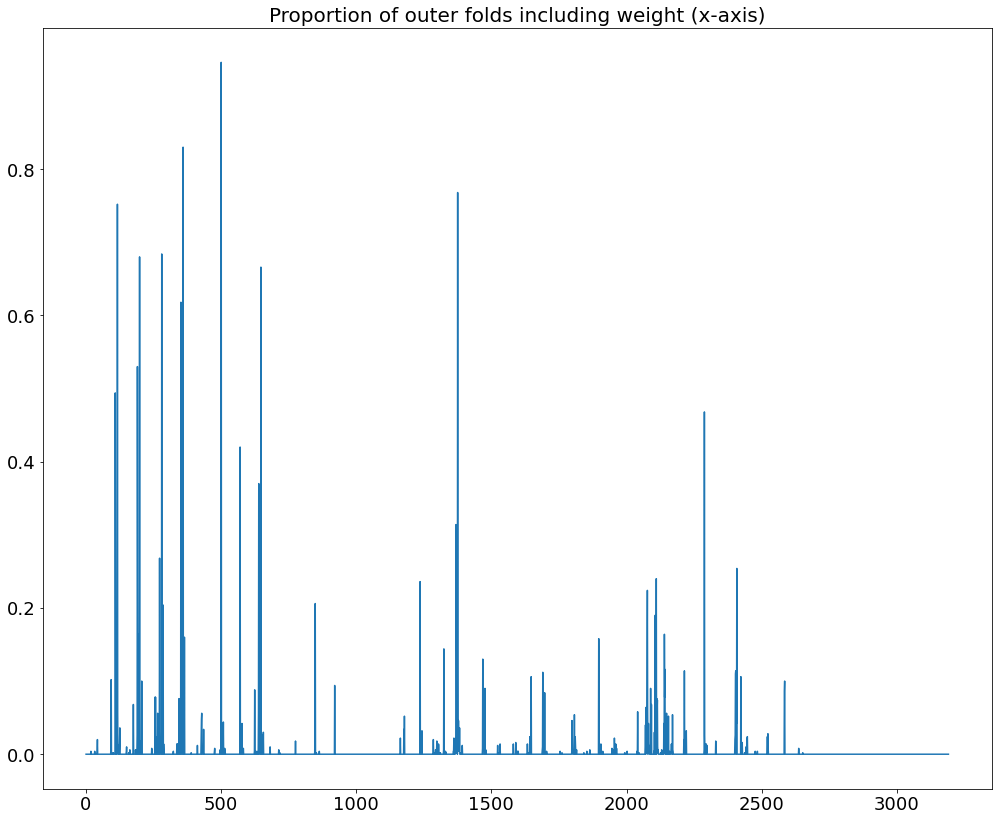

In [97]:
plt.figure(figsize=(17,14))

plt.plot(countweights/500)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Proportion of outer folds including weight (x-axis)', fontsize =20)


Text(0.5, 1.0, 'Number of times each SC edge was used in outer loop of cross-validation (max = 500)')

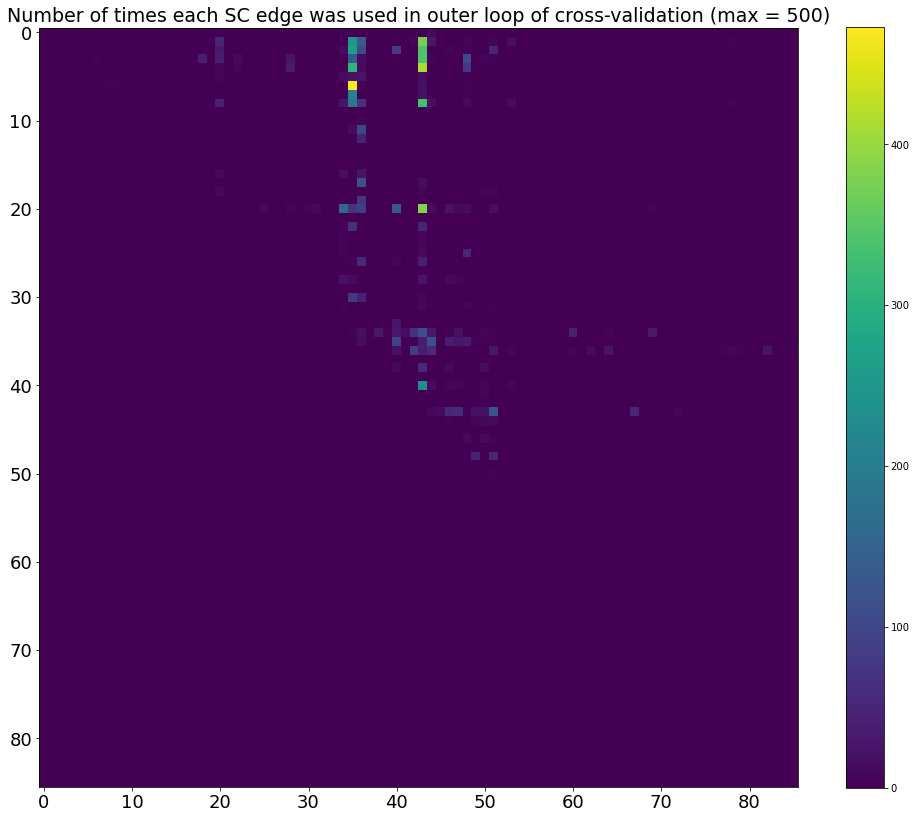

In [225]:
# convert vectorized Triu to matrix
highweights = countweights > 250

# get weights back to matrix form 86x86
# remove inputs that are 0 for all subjects
X=sc
zeros=X==0
zeros=np.sum(zeros,0) # number of zeros across subjects
zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
tmp=np.ones(shape=(3192, 1))

zeroidx=np.arange(0, 3655)
zeroidx=zeroidx[zeros]

# fill spots with 0's
k=0
cnt = countweights
while k < zeroidx.shape[0]:
    cnt=np.insert(cnt, zeroidx[k],0)
    tmp=np.insert(tmp, zeroidx[k],0)

    k=k+1
    
plt.figure(figsize=(17,14))

fs86_counts = np.zeros((86, 86))
inds = np.triu_indices(86, k=1)
fs86_counts[inds] = cnt

plt.imshow(fs86_counts)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.colorbar()
plt.title('Number of times each SC edge was used in outer loop of cross-validation (max = 500)', fontsize = 19)

In [223]:
print(sc.shape)

(101, 3192)


/home/ubuntu/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays/_projectors.py:166: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "


<Figure size 1224x1008 with 0 Axes>

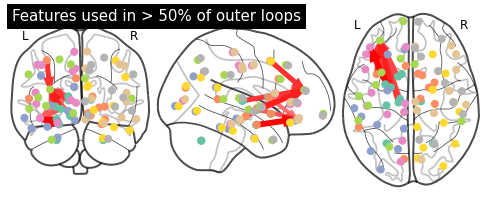

In [101]:
from nilearn import datasets
from nilearn import plotting

plt.figure(figsize=(17,14))

coordinates = plotting.find_parcellation_cut_coords('fs86_allsubj_mode.nii.gz')
plotting.plot_connectome(fs86_counts, coordinates,
                         edge_threshold=250,
                         title='Features used in > 50% of outer loops')

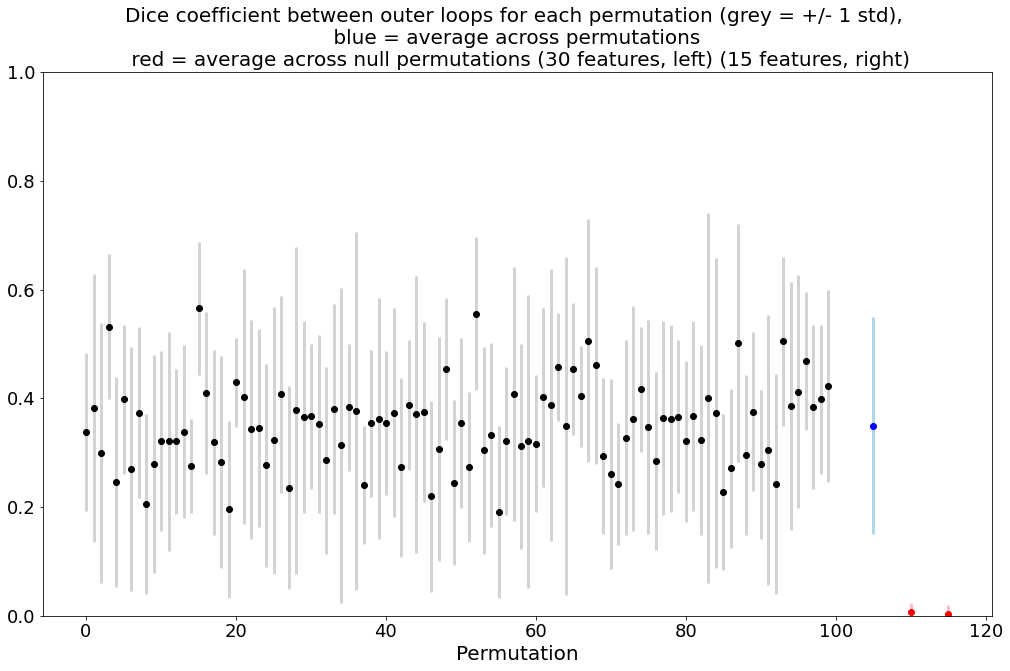

In [98]:
plt.figure(figsize=(17,10))
plt.errorbar(range(0,100), alldice, yerr=alldicestd, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0);

plt.ylim([0, 1])
plt.title('Dice coefficient between outer loops for each permutation (grey = +/- 1 std), \n blue = average across permutations \n red = average across null permutations (30 features, left) (15 features, right)' , fontsize=20)
plt.xlabel('Permutation', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.errorbar(105, np.mean(allalldice), yerr=np.std(allalldice), fmt='o', color='blue',
             ecolor='lightblue', elinewidth=3, capsize=0);

plt.errorbar(110, np.mean(allalldice_null), yerr=np.std(allalldice_null), fmt='o', color='red',
             ecolor='pink', elinewidth=3, capsize=0);

plt.errorbar(115, np.mean(allalldice_null2), yerr=np.std(allalldice_null2), fmt='o', color='red',
             ecolor='pink', elinewidth=3, capsize=0);

In [243]:
# Haufe transformation of feature weights
k=5


Y = np.array(wais)

# load activation weights
with open(results_dir + 'correlation' + 'p99_SC_varimpt.pkl', 'rb') as f:
    activ = pickle.load(f)

perm=0
fullactivations=[]
#iterate through permutations
for p in range(99):
    k=5
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    
    # Load features selected from permutation
    with open(results_dir + 'correlation' + 'p' + str(p) + '_SC_features.pkl', 'rb') as f:
        feats = pickle.load(f)
        
    c=0   
    activations=[]
    X=sc
    X=prepare_data(X)
    for train, test in outer_cv.split(X):

        # get activation weights of only the features (SC weights) selected in the loop
        X_sub=X[train,feats[c][:]]
        X_sub=np.reshape(X_sub, [len(train),feats[c].shape[0]])
        cov_x=np.cov(np.transpose(X_sub))
        cov_y=np.cov(np.transpose(Y[train]))
        weight=np.transpose(activ[p][c])
        activation=np.matmul(cov_x,weight)*(1/cov_y)
        activations.append(activation)
        
        # get activation weights back to matrix form 86x86
        # get indices of weights not selected as features; set weight to 0    
        idx=np.ones(shape=(3192,1), dtype='bool')
        idx[feats[c]]=False # set SC weights that are features to be 1
        idx=idx.flatten()
        zeroidx=np.arange(0, 3192, dtype='int')
        zeroidx=zeroidx[idx]
        
        # fill spots with 0's (up to 3192)
        k=0
        activation_full = activation
        while k < 3162:
            activation_full=np.insert(activation_full, zeroidx[k],0)
            k=k+1
        
        # fill spots with 0's (up to 3655)
        X=sc
        zeros=sc==0
        zeros=np.sum(zeros,0) # number of zeros across subjects
        zeros=zeros==X.shape[0] # find columns with zeros for all 101 subjects
        X=X[:,~zeros]
        
        zeroidx=np.arange(0, 3655)
        zeroidx=zeroidx[zeros]

        # fill spots with 0's
        k=0
        a = activation_full
        while k < zeroidx.shape[0]:
            print(a.shape)
            a=np.insert(a, zeroidx[k],0)
            k=k+1

        fullactivations.append(a)

Final size of X: (101, 3192)
(3192,)
(3193,)
(3194,)
(3195,)
(3196,)
(3197,)
(3198,)
(3199,)
(3200,)
(3201,)
(3202,)
(3203,)
(3204,)
(3205,)
(3206,)
(3207,)
(3208,)
(3209,)
(3210,)
(3211,)
(3212,)
(3213,)
(3214,)
(3215,)
(3216,)
(3217,)
(3218,)
(3219,)
(3220,)
(3221,)
(3222,)
(3223,)
(3224,)
(3225,)
(3226,)
(3227,)
(3228,)
(3229,)
(3230,)
(3231,)
(3232,)
(3233,)
(3234,)
(3235,)
(3236,)
(3237,)
(3238,)
(3239,)
(3240,)
(3241,)
(3242,)
(3243,)
(3244,)
(3245,)
(3246,)
(3247,)
(3248,)
(3249,)
(3250,)
(3251,)
(3252,)
(3253,)
(3254,)
(3255,)
(3256,)
(3257,)
(3258,)
(3259,)
(3260,)
(3261,)
(3262,)
(3263,)
(3264,)
(3265,)
(3266,)
(3267,)
(3268,)
(3269,)
(3270,)
(3271,)
(3272,)
(3273,)
(3274,)
(3275,)
(3276,)
(3277,)
(3278,)
(3279,)
(3280,)
(3281,)
(3282,)
(3283,)
(3284,)
(3285,)
(3286,)
(3287,)
(3288,)
(3289,)
(3290,)
(3291,)
(3292,)
(3293,)
(3294,)
(3295,)
(3296,)
(3297,)
(3298,)
(3299,)
(3300,)
(3301,)
(3302,)
(3303,)
(3304,)
(3305,)
(3306,)
(3307,)
(3308,)
(3309,)
(3310,)
(3311,)
(3312,)
(33

(3284,)
(3285,)
(3286,)
(3287,)
(3288,)
(3289,)
(3290,)
(3291,)
(3292,)
(3293,)
(3294,)
(3295,)
(3296,)
(3297,)
(3298,)
(3299,)
(3300,)
(3301,)
(3302,)
(3303,)
(3304,)
(3305,)
(3306,)
(3307,)
(3308,)
(3309,)
(3310,)
(3311,)
(3312,)
(3313,)
(3314,)
(3315,)
(3316,)
(3317,)
(3318,)
(3319,)
(3320,)
(3321,)
(3322,)
(3323,)
(3324,)
(3325,)
(3326,)
(3327,)
(3328,)
(3329,)
(3330,)
(3331,)
(3332,)
(3333,)
(3334,)
(3335,)
(3336,)
(3337,)
(3338,)
(3339,)
(3340,)
(3341,)
(3342,)
(3343,)
(3344,)
(3345,)
(3346,)
(3347,)
(3348,)
(3349,)
(3350,)
(3351,)
(3352,)
(3353,)
(3354,)
(3355,)
(3356,)
(3357,)
(3358,)
(3359,)
(3360,)
(3361,)
(3362,)
(3363,)
(3364,)
(3365,)
(3366,)
(3367,)
(3368,)
(3369,)
(3370,)
(3371,)
(3372,)
(3373,)
(3374,)
(3375,)
(3376,)
(3377,)
(3378,)
(3379,)
(3380,)
(3381,)
(3382,)
(3383,)
(3384,)
(3385,)
(3386,)
(3387,)
(3388,)
(3389,)
(3390,)
(3391,)
(3392,)
(3393,)
(3394,)
(3395,)
(3396,)
(3397,)
(3398,)
(3399,)
(3400,)
(3401,)
(3402,)
(3403,)
(3404,)
(3405,)
(3406,)
(3407,)
(3408,)


IndexError: index 3645 is out of bounds for axis 0 with size 3642

In [242]:
zeroidx[-1]

3650

In [98]:
p=7
with open(results_dir + str(p) + '_SC_activation.pkl', 'rb') as f:
    actv = pickle.load(f)
    

# fill spots not included with 0's


k=0
cnt = countweights
while k < zeroidx.shape[0]:
    cnt=np.insert(cnt, zeroidx[k],0)
    tmp=np.insert(tmp, zeroidx[k],0)

    k=k+1
    

[array([[1925582.65366281],
        [2405714.58982074],
        [2419277.89515981],
        [2243588.83290634],
        [2648931.79862689],
        [2649934.24957467],
        [2646938.64708022],
        [2491557.24395594],
        [2345756.57553854],
        [2200114.17213861],
        [2108551.37552105]]),
 array([[3664301.34589006],
        [3663585.4212226 ],
        [3618954.16588551],
        [3687243.42122871],
        [3678857.22717146],
        [3689211.26237718],
        [3712599.19114368],
        [3752310.60252336],
        [3754124.53465156],
        [3783569.43272223],
        [2684868.88542662],
        [3748352.07857105],
        [2857707.45408792],
        [3347793.39910859],
        [3689976.54976272],
        [3233545.36554919],
        [4906025.68967147],
        [4903529.71882212],
        [4762261.95202394],
        [5270542.436122  ],
        [4031342.82773614],
        [5239241.25614063],
        [5252030.74835774],
        [4621799.56660675],
        [5248983.2

Final size of X: (101, 1)


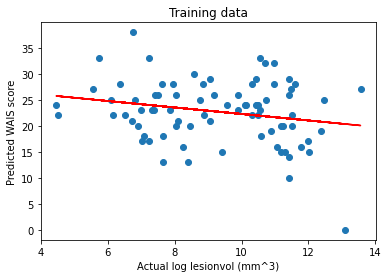

/home/ubuntu/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


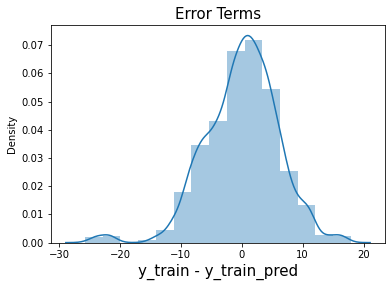

Verify that mean of residuals is zero. 
 Mean of error terms: 5.826450433232821e-15
R-squared: 0.0010299090412728695


In [6]:
import statsmodels.api as sm

# Simple linear model - using lesion volume to predict cognitive scores

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=lesionvol
X=prepare_data(X)
train_size=0.8

#set y to be the measure you want to predict
Y = np.array(wais)

# split data into train/test
x, x_test, y, y_test = train_test_split(X, Y, test_size=1-train_size, shuffle=True, random_state=41)

x_sm = sm.add_constant(x)
lr = sm.OLS(y, x_sm).fit()

lr.summary()
plt.scatter(x, y)
pms=lr.params

plt.plot(x, pms[0] + pms[1]*x, 'r')
plt.xlabel('Actual log lesionvol (mm^3)')
plt.ylabel('Predicted WAIS score')
plt.title('Training data')
plt.show()


# Predicting y_value using training data of X
y_train_pred = lr.predict(x_sm)

# Creating residuals from the y_train data and predicted y_data
res = (y - y_train_pred)

fig = plt.figure()
sns.distplot(res, bins = 15)
plt.title('Error Terms', fontsize = 15)
plt.xlabel('y_train - y_train_pred', fontsize = 15)
plt.show()

print('Verify that mean of residuals is zero. \n Mean of error terms: ' + str(np.mean(res)))

# Adding a constant to X_test
X_test_sm = sm.add_constant(x_test)

# Predicting the y values corresponding to X_test_sm
y_test_pred = lr.predict(X_test_sm)

# Checking the R-squared value
r_squared = r2_score(y_test, y_test_pred)
r_squared
print('R-squared: ' + str(r_squared))


In [ ]:
# Using PCA of the lesion in MNi space to predict cognitive scores.

import datetime
#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=image
X=prepare_image_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# feature selection type
featselect='PCA'

# range of alphas
n_alphas=20
alpha_start=-1
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

#number of features (# pricipal components or variables to retain)
feat_start=10
feat_end=20
n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]
allexpl_var=[]
#joblib-based parallelism to increase speed


for p in range(0, 100):
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    featur=[]
    best_alphas=[]
    impt=[] 
    expl_var=[]
    for train, test in outer_cv.split(X):
        begin_time = datetime.datetime.now()
        
        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)
        
        # using optimal num. of features, select final features using entire training data.
 
        if featselect=='correlation':
            x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
            featur.append(ind)
            
        elif featselect=='PCA':
            x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
            featur.append(ind)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        expl_var.append(explained_variance_score(Y[test], y_pred))

        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
        print("R2 loop: " + str(r2_score(Y[test], y_pred)))
        print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
        print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

    # store results for each permutation p

    allexpl_var.append(expl_var)
    bestalphas.append(best_alphas)
    importance.append(impt)
    print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

    np.savetxt(results_dir + featselect + 'p' + str(p) + '_lesion_all_explvar.txt', expl_var, delimiter=',')

    output = open(results_dir + featselect + 'p' + str(p) + '_lesion_features.pkl', 'wb')
    pickle.dump(featur, output)
    output.close()

    output = open(results_dir + featselect + 'p' + str(p) + '_lesion_bestalphas.pkl', 'wb')
    pickle.dump(best_alphas, output)
    output.close()


Final size of X: (101, 902629)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set


In [56]:
# Functional Connectivity 

import datetime
#set the number of folds you want in the inner and outer folds of the nested cross-validation
k = 5

#set the proportion of data you want in your training set
train_size = .8

#set x data to be the input variable you want to use
#ie fc, sc, or hc
#X=np.concatenate([sc, fc], axis=1)
X=fc
X=prepare_data(X)

#set y to be the measure you want to predict
Y = np.array(wais)

# feature selection type
featselect='PCA'

# range of alphas
n_alphas=20
alpha_start=-1
alpha_end=2
alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

#number of features (# pricipal components or variables to retain)
feat_start=10
feat_end=30
n_feats=feat_end-feat_start+1
feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

# initialize lists to store model results for each permuation
allR2=[]
meanR2=[]
features=[]
bestalphas=[]
importance=[]
allexpl_var=[]
#joblib-based parallelism to increase speed,

for p in range(0, 100):
    outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
    print('Permutation: ' + str(p))
    # initialize lists to store model results for eah fold
    R2=[]
    featur=[]
    best_alphas=[]
    impt=[] 
    expl_var=[]
    for train, test in outer_cv.split(X):
        begin_time = datetime.datetime.now()
        
        # select model using training data
        bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)
        
        # using optimal num. of features, select final features using entire training data.
 
        if featselect=='correlation':
            x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
            featur.append(ind)
            
        elif featselect=='PCA':
            x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
            featur.append(ind)

        # initialize Ridge regression with alpha selected from hyperparameter search
        regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

        # fit model 
        y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

        # store results for each fold k
        impt.append(regr.coef_)
        R2.append(r2_score(Y[test], y_pred))
        expl_var.append(explained_variance_score(Y[test], y_pred))

        best_alphas.append(bestalpha)
        print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
        print("R2 loop: " + str(r2_score(Y[test], y_pred)))
        print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
        print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

    # store results for each permutation p

    allexpl_var.append(expl_var)
    bestalphas.append(best_alphas)
    importance.append(impt)
    print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

    np.savetxt(results_dir + featselect + 'p' + str(p) + '_FC_all_explvar.txt', expl_var, delimiter=',')

    output = open(results_dir + featselect + 'p' + str(p) + '_FC_features.pkl', 'wb')
    pickle.dump(featur, output)
    output.close()

    output = open(results_dir + featselect + 'p' + str(p) + '_FC_bestalphas.pkl', 'wb')
    pickle.dump(best_alphas, output)
    output.close()


Final size of X: (101, 3655)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.943851
R2 loop: 0.08725713909177901
Explained var: 0.13015329181304736
correlation: [[0.4859394]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.023496
R2 loop: -0.042102289306928053
Explained var: 0.1000335577592052
correlation: [[0.33519712]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.050199
R2 loop: -0.033714981097657803
Explained var: 0.11728474378817944
correlation: [[0.41664356]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.068258
R2 loop: 0.13813398258424248
Explained var: 0.19102031432312272
correlation: [[0.46956806]]
5-fold cross-v

time to run loop: 0:00:09.958254
R2 loop: -0.2272411080435801
Explained var: -0.08823804402848756
correlation: [[-0.00569989]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.125986
R2 loop: 0.36339667889785343
Explained var: 0.3698844641563934
correlation: [[0.71596751]]
Permutation avg. explained variance: 0.06525139934838005
Permutation: 7
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.005382
R2 loop: -0.08347379700809232
Explained var: -0.08321557595772155
correlation: [[0.24179643]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.069382
R2 loop: 0.14781105465094402
Explained var: 0.18019839848059627
correlation: [[0.68528379]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the 

time to run loop: 0:00:10.103544
R2 loop: 0.00445618880906129
Explained var: 0.03871405839538311
correlation: [[0.22964426]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.303263
R2 loop: 0.17140105203521827
Explained var: 0.23722806999600066
correlation: [[0.51800497]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.146447
R2 loop: -0.21508380988363762
Explained var: -0.17329531923466823
correlation: [[0.09717486]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.212280
R2 loop: 0.27986292792318745
Explained var: 0.2799085786697725
correlation: [[0.65207874]]
Permutation avg. explained variance: 0.026684153809160983
Permutation: 14
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the 

time to run loop: 0:00:10.066944
R2 loop: -0.10598397332286114
Explained var: 0.02861416062153488
correlation: [[0.28149249]]
Permutation avg. explained variance: 0.015014331347291642
Permutation: 20
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.040386
R2 loop: -0.10555038966588914
Explained var: -0.0458662651737487
correlation: [[0.23430459]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.224206
R2 loop: 0.14230836392396506
Explained var: 0.1603438547977344
correlation: [[0.40043032]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.172765
R2 loop: 0.2663025307478569
Explained var: 0.3679978765958327
correlation: [[0.66342942]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:10.100267
R2 loop: -0.229855736057071
Explained var: -0.1624339983957721
correlation: [[-0.13776782]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.996453
R2 loop: 0.0358540810693988
Explained var: 0.15013694507053865
correlation: [[0.38877237]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.125129
R2 loop: 0.17172069399966317
Explained var: 0.1738502107470209
correlation: [[0.4428869]]
Permutation avg. explained variance: 0.12159253941849826
Permutation: 27
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.202153
R2 loop: -0.18471565596518102
Explained var: -0.15447127280363948
correlation: [[0.21079301]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the val

time to run loop: 0:00:09.946170
R2 loop: 0.28417227591510197
Explained var: 0.3151600801719846
correlation: [[0.5669632]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.187399
R2 loop: 0.12894196496214305
Explained var: 0.18383647357811705
correlation: [[0.48044193]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.192928
R2 loop: -0.020803133796630124
Explained var: -0.018538139741217208
correlation: [[0.20677026]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.165177
R2 loop: -0.12492525561028067
Explained var: -0.10391856023339341
correlation: [[0.03544022]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.891796
R2 loop: 0.236719261811

time to run loop: 0:00:10.098149
R2 loop: 0.07630340135305602
Explained var: 0.21822589385753133
correlation: [[0.57977422]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.169518
R2 loop: 0.12201721833233081
Explained var: 0.22447163917515955
correlation: [[0.56281665]]
Permutation avg. explained variance: 0.07937851614581573
Permutation: 40
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.930441
R2 loop: 0.0831752982769155
Explained var: 0.09357113391951044
correlation: [[0.35461995]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.972430
R2 loop: 0.1249297278151954
Explained var: 0.19524305442734347
correlation: [[0.69278372]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the vali

time to run loop: 0:00:10.240011
R2 loop: 0.12292524004057159
Explained var: 0.17213930922209353
correlation: [[0.64437154]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.162321
R2 loop: 0.14199611103156484
Explained var: 0.1590468278458087
correlation: [[0.41068439]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.021356
R2 loop: 0.2425226261834098
Explained var: 0.24645022582959497
correlation: [[0.52914532]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.086523
R2 loop: 0.07102278803787154
Explained var: 0.0720233542710188
correlation: [[0.27164184]]
Permutation avg. explained variance: 0.1715465240511528
Permutation: 47
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the valida

time to run loop: 0:00:10.310962
R2 loop: 0.10832935036696756
Explained var: 0.1106891939098601
correlation: [[0.41547326]]
Permutation avg. explained variance: 0.0909246750109276
Permutation: 53
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.837022
R2 loop: 0.20067475757086384
Explained var: 0.20805135206673298
correlation: [[0.5271029]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.070595
R2 loop: -0.07908373370061517
Explained var: -0.07370909564699213
correlation: [[0.07508659]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.229571
R2 loop: 0.11503491943776822
Explained var: 0.15711211107622736
correlation: [[0.40628262]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the val

time to run loop: 0:00:10.085263
R2 loop: 0.3019579651096139
Explained var: 0.35004873228831146
correlation: [[0.74301007]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.223179
R2 loop: 0.15593953146697648
Explained var: 0.18455765549268865
correlation: [[0.46370167]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.073411
R2 loop: 0.2601257112666202
Explained var: 0.26104484704558706
correlation: [[0.5111797]]
Permutation avg. explained variance: 0.17948398868219517
Permutation: 60
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.880908
R2 loop: -0.2960920333701793
Explained var: -0.1698702220508821
correlation: [[-0.18754921]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the vali

time to run loop: 0:00:09.947693
R2 loop: -0.21698970102297532
Explained var: -0.06371393231169908
correlation: [[0.05066377]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.070092
R2 loop: 0.16893799666622256
Explained var: 0.23791447287135314
correlation: [[0.53597988]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.066998
R2 loop: -0.2984445530347337
Explained var: -0.10750666618882021
correlation: [[0.07021053]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.173816
R2 loop: 0.1588583615247533
Explained var: 0.2034557576815007
correlation: [[0.52861129]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.074945
R2 loop: 0.078436450213054

time to run loop: 0:00:10.073909
R2 loop: 0.16164170269668965
Explained var: 0.2224507596051133
correlation: [[0.5711146]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.206033
R2 loop: -0.1430222379959878
Explained var: 0.07478688063187955
correlation: [[0.27380183]]
Permutation avg. explained variance: 0.08150380178350028
Permutation: 73
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:10.127232
R2 loop: -0.03182820448229173
Explained var: 0.12746933068237265
correlation: [[0.37072505]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:10.018480
R2 loop: 0.2916497199900172
Explained var: 0.2916544834336464
correlation: [[0.68328757]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the valid

time to run loop: 0:00:09.401401
R2 loop: -0.10643652679129478
Explained var: -0.10367322187056138
correlation: [[0.26257351]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.311020
R2 loop: 0.03065654690050268
Explained var: 0.1195030058916774
correlation: [[0.35367284]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.375130
R2 loop: -0.023116350779613937
Explained var: 0.13442140137333736
correlation: [[0.37088639]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.415345
R2 loop: 0.21265987481443838
Explained var: 0.212660404745329
correlation: [[0.50571018]]
Permutation avg. explained variance: 0.1008310081028555
Permutation: 80
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the va

time to run loop: 0:00:09.731067
R2 loop: -0.05870527536852954
Explained var: 0.03931679292052259
correlation: [[0.20424972]]
Permutation avg. explained variance: 0.19110934144341185
Permutation: 86
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.451521
R2 loop: 0.1919366380941524
Explained var: 0.20296916767458117
correlation: [[0.53413915]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.450679
R2 loop: 0.10336558242442073
Explained var: 0.10447630240174843
correlation: [[0.36215935]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.554578
R2 loop: 0.21861155415258482
Explained var: 0.21881528004379702
correlation: [[0.46869215]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:09.452210
R2 loop: 0.052636304858766136
Explained var: 0.06299620928299121
correlation: [[0.25588088]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.614184
R2 loop: 0.24581002103495164
Explained var: 0.24811660052898432
correlation: [[0.49862026]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.552261
R2 loop: -0.03193098892712176
Explained var: 0.017423086108217856
correlation: [[0.35299718]]
Permutation avg. explained variance: 0.13262060833626163
Permutation: 93
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:09.302492
R2 loop: 0.23954532522104244
Explained var: 0.25188836949352855
correlation: [[0.52803408]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:09.679744
R2 loop: -0.07071511346363679
Explained var: -0.057809905210901125
correlation: [[0.19968947]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.914094
R2 loop: 0.10309215456679055
Explained var: 0.22170812854875765
correlation: [[0.60540122]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.538237
R2 loop: -0.06109368777806368
Explained var: -0.03477172294611797
correlation: [[0.09326905]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.765448
R2 loop: 0.028235866381595587
Explained var: 0.12779605918149006
correlation: [[0.3823278]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:09.727813
R2 loop: 0.41212051403

In [10]:
# predictions for FC (node) - PCA and correlation

import datetime

# feature selection type
f=['correlation', 'PCA']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #set x data to be the input variable you want to use
    #ie fc, sc, or hc
    #X=np.concatenate([sc, fc], axis=1)
    X=fc_n
    X=prepare_data(X)

    #set y to be the measure you want to predict
    Y = np.array(wais)


    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=10
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)

            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

        np.savetxt(results_dir + featselect + 'p' + str(p) + '_FCn_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_FCn_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_FCn_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
        


Final size of X: (101, 86)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:02.178083
R2 loop: 0.07394512584719448
Explained var: 0.09305103902910405
correlation: [[0.40141334]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.240586
R2 loop: -0.2368757558225214
Explained var: -0.028671472923573305
correlation: [[0.05460586]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.199235
R2 loop: 0.014499800231772886
Explained var: 0.13442294295769142
correlation: [[0.39495908]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.192819
R2 loop: 0.05841683626553029
Explained var: 0.10350039879191975
correlation: [[0.51243111]]
5-fold cross-va

time to run loop: 0:00:01.248922
R2 loop: -0.4425671095906156
Explained var: -0.2874165435448235
correlation: [[-0.05624848]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.221376
R2 loop: 0.08159418455490197
Explained var: 0.0872918026055638
correlation: [[0.4768978]]
Permutation avg. explained variance: -0.013978233199189116
Permutation: 7
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.293331
R2 loop: 0.056574963648445276
Explained var: 0.05740653937331763
correlation: [[0.31846642]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.224777
R2 loop: 0.00018082347423142853
Explained var: 0.030693329523585278
correlation: [[0.63268593]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in t

time to run loop: 0:00:01.341785
R2 loop: -0.0033021310968301965
Explained var: 0.016642746423064625
correlation: [[0.12978736]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.215701
R2 loop: -0.23769913773384643
Explained var: -0.1851261402824591
correlation: [[0.22692952]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.137244
R2 loop: -0.24091889506187192
Explained var: -0.11976343630322384
correlation: [[0.1446492]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.216182
R2 loop: 0.07645721928424487
Explained var: 0.0919847643635201
correlation: [[0.41301421]]
Permutation avg. explained variance: -0.038118639176706146
Permutation: 14
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in

time to run loop: 0:00:01.245350
R2 loop: 0.046905405414921164
Explained var: 0.1316180570871106
correlation: [[0.36505864]]
Permutation avg. explained variance: -0.09087196246142182
Permutation: 20
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.311772
R2 loop: -0.2583441547134957
Explained var: -0.11783318449582136
correlation: [[0.08684674]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.198960
R2 loop: -0.03129383896379445
Explained var: -0.0165911599207349
correlation: [[0.14085806]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.185071
R2 loop: 0.12123167118732026
Explained var: 0.25150813165992925
correlation: [[0.60895662]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.263933
R2 loop: -0.1386485394498611
Explained var: -0.028363533672589814
correlation: [[0.09130536]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.351351
R2 loop: -0.09365349484336005
Explained var: 0.09933422213893894
correlation: [[0.31647705]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.243264
R2 loop: 0.0874411026053703
Explained var: 0.09064045127084686
correlation: [[0.30136694]]
Permutation avg. explained variance: 0.030807811814263463
Permutation: 27
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.292877
R2 loop: -0.4122196450888893
Explained var: -0.4097406842527058
correlation: [[0.0352868]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the 

time to run loop: 0:00:01.302780
R2 loop: 0.07900791391047246
Explained var: 0.11082943670803935
correlation: [[0.33300245]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.198480
R2 loop: 0.07718245936647494
Explained var: 0.15714027717168721
correlation: [[0.42762578]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.227964
R2 loop: -0.2583838044630413
Explained var: -0.24190760911258247
correlation: [[-0.06222291]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.296565
R2 loop: 0.032894622853447575
Explained var: 0.05368871422534727
correlation: [[0.23575343]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.221985
R2 loop: 0.2011354376193

time to run loop: 0:00:01.206674
R2 loop: -0.10298286868011886
Explained var: 0.06053681248554044
correlation: [[0.31061598]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.264399
R2 loop: 0.06657662925532293
Explained var: 0.14776585325212155
correlation: [[0.42185233]]
Permutation avg. explained variance: 0.021370114385979043
Permutation: 40
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.211093
R2 loop: -0.015801383059283358
Explained var: 0.0010113529255412201
correlation: [[0.11374915]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.257680
R2 loop: -0.05270673830552153
Explained var: 0.00854534394158557
correlation: [[0.21567097]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in

time to run loop: 0:00:01.132136
R2 loop: 0.01932871165131389
Explained var: 0.06334364805937243
correlation: [[0.26893515]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.297652
R2 loop: 0.08756494072423449
Explained var: 0.1632018839252184
correlation: [[0.4163914]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.225824
R2 loop: -0.026916024901896263
Explained var: -0.016940598423439646
correlation: [[0.2447331]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.259576
R2 loop: -0.1766318073763169
Explained var: -0.12420873668386645
correlation: [[0.08222045]]
Permutation avg. explained variance: 0.05231033647939529
Permutation: 47
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the 

time to run loop: 0:00:01.176136
R2 loop: 0.06038337519304415
Explained var: 0.06450838091691324
correlation: [[0.66123077]]
Permutation avg. explained variance: -0.01169653427666928
Permutation: 53
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.290512
R2 loop: -0.013585294426250893
Explained var: -0.00994195705367451
correlation: [[-0.01189198]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.202045
R2 loop: -0.036321278960057324
Explained var: -0.033224183007911634
correlation: [[-0.00533202]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.238027
R2 loop: -0.29935773490048767
Explained var: -0.1334819791619144
correlation: [[0.15571454]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subject

time to run loop: 0:00:01.189672
R2 loop: 0.3141542940857567
Explained var: 0.3268088908625635
correlation: [[0.60467361]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.209970
R2 loop: 0.037282825356328986
Explained var: 0.056038974663805585
correlation: [[0.23786856]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.226396
R2 loop: 0.08099297086028157
Explained var: 0.12331933792814931
correlation: [[0.3684004]]
Permutation avg. explained variance: 0.11186753161750373
Permutation: 60
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.114242
R2 loop: -0.06878288416752265
Explained var: 0.07825230098113312
correlation: [[0.29790313]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.149489
R2 loop: -0.38394982013564194
Explained var: -0.107994533243986
correlation: [[0.04845732]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.229977
R2 loop: -0.03199996398853355
Explained var: 0.09515140255563548
correlation: [[0.53349634]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.221836
R2 loop: -0.0891886280171732
Explained var: 0.06756884975267008
correlation: [[0.29173964]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.242692
R2 loop: 0.027936909965209034
Explained var: 0.11143903359443585
correlation: [[0.42527461]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.328013
R2 loop: 0.03034541826080

time to run loop: 0:00:01.181490
R2 loop: 0.3388265527141575
Explained var: 0.35625578391576007
correlation: [[0.64048252]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.239686
R2 loop: -0.27637168438040294
Explained var: -0.10905014184161299
correlation: [[-0.09658049]]
Permutation avg. explained variance: 0.10759182713540269
Permutation: 73
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.294202
R2 loop: -0.04918251410635199
Explained var: 0.12059173927199718
correlation: [[0.35111903]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.077287
R2 loop: 0.14121059678434922
Explained var: 0.15238732990579174
correlation: [[0.403817]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.171795
R2 loop: -0.120363542913831
Explained var: -0.11198140175946314
correlation: [[0.21328698]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.207258
R2 loop: 0.013382523181615813
Explained var: 0.09772027501351055
correlation: [[0.68138711]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.320027
R2 loop: -0.23551987070703895
Explained var: -0.05098664384355511
correlation: [[0.04369085]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.096135
R2 loop: 0.010292303015160154
Explained var: 0.01038158449041593
correlation: [[0.13770787]]
Permutation avg. explained variance: 0.02098885925746703
Permutation: 80
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in th

time to run loop: 0:00:01.253587
R2 loop: -0.18554557168954644
Explained var: 0.009134484089706518
correlation: [[0.10111094]]
Permutation avg. explained variance: 0.04536527732948694
Permutation: 86
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.300993
R2 loop: 0.05197930118885463
Explained var: 0.08986432084192408
correlation: [[0.32631773]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.273807
R2 loop: 0.030165765392632826
Explained var: 0.05540965979154855
correlation: [[0.2359509]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.352151
R2 loop: 0.09454414236028441
Explained var: 0.09679139772354806
correlation: [[0.3112436]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.303537
R2 loop: -0.07628992799753309
Explained var: -0.04322732030660892
correlation: [[0.02398984]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.314631
R2 loop: 0.07379019754104965
Explained var: 0.07990010080734944
correlation: [[0.28539251]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.360845
R2 loop: 0.0658032700546275
Explained var: 0.14212822759650134
correlation: [[0.38166228]]
Permutation avg. explained variance: -0.0008448761206772514
Permutation: 93
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.364906
R2 loop: -0.009272505334307235
Explained var: 0.0095183711808281
correlation: [[0.12593308]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in t

time to run loop: 0:00:01.264870
R2 loop: -0.014490327235094913
Explained var: 0.008893664850417426
correlation: [[0.18587047]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.235572
R2 loop: 0.007029947075956278
Explained var: 0.10688675567247252
correlation: [[0.4523015]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.245634
R2 loop: -0.17436696649115357
Explained var: -0.14855085428007442
correlation: [[-0.10969915]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.261386
R2 loop: -0.06473402759186908
Explained var: 0.014851377750326522
correlation: [[0.27152332]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.253193
R2 loop: 0.10523599

time to run loop: 0:00:01.562945
R2 loop: -0.3390712685909527
Explained var: -0.08324908408784104
correlation: [[-0.03962343]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.603850
R2 loop: 0.246340803500673
Explained var: 0.29620228057994413
correlation: [[0.66448928]]
Permutation avg. explained variance: -0.08802677291214422
Permutation: 6
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.593504
R2 loop: -0.4106138542015332
Explained var: -0.36750386415163816
correlation: [[-0.24211434]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.618090
R2 loop: 0.04211339700728445
Explained var: 0.045067398036299555
correlation: [[0.31692955]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.583726
R2 loop: 0.08130766270190803
Explained var: 0.1329718650471612
correlation: [[0.44224721]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.569920
R2 loop: 0.25614756978493713
Explained var: 0.3487616845000122
correlation: [[0.59318612]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.559193
R2 loop: 0.0952122209293661
Explained var: 0.1005717068819737
correlation: [[0.38310194]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.595620
R2 loop: -0.0264055616875547
Explained var: 0.13121359654900278
correlation: [[0.36223455]]
Permutation avg. explained variance: 0.16152874067756842
Permutation: 13
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the valida

time to run loop: 0:00:01.634196
R2 loop: 0.2234948803852258
Explained var: 0.30967638831490896
correlation: [[0.62246424]]
Permutation avg. explained variance: 0.03515081568087788
Permutation: 19
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.540468
R2 loop: -0.043508358178034445
Explained var: -0.032982117694492
correlation: [[0.17246244]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.550001
R2 loop: -0.6081630450430262
Explained var: -0.6051877212725396
correlation: [[0.01281844]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.616004
R2 loop: -0.3237642666479503
Explained var: -0.15367175079313555
correlation: [[-0.1127989]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.589676
R2 loop: -0.3309773345859799
Explained var: -0.2215627968750442
correlation: [[-0.02505567]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.665948
R2 loop: -0.0993666497144281
Explained var: 0.19013632137252479
correlation: [[0.4849956]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.623792
R2 loop: -0.004421947296751272
Explained var: 0.041381461046611556
correlation: [[0.20520954]]
Permutation avg. explained variance: -0.026525412129344828
Permutation: 26
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.567033
R2 loop: 0.10035422998514865
Explained var: 0.13738232319703725
correlation: [[0.37222148]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in t

time to run loop: 0:00:01.540789
R2 loop: -0.1763101649329757
Explained var: -0.09644995563423997
correlation: [[0.0074005]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.624824
R2 loop: -0.5029833540866571
Explained var: 0.07158016692960856
correlation: [[0.32356012]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.677407
R2 loop: 0.22895670286018754
Explained var: 0.284902402810741
correlation: [[0.64043601]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.583332
R2 loop: -0.010962020916319926
Explained var: -0.010323760092894929
correlation: [[0.21312145]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.622831
R2 loop: 0.06577409332955

time to run loop: 0:00:01.588695
R2 loop: -0.4538697501348188
Explained var: -0.419563259389637
correlation: [[-0.1574278]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.634419
R2 loop: 0.11406906959294993
Explained var: 0.11491615169285585
correlation: [[0.3514287]]
Permutation avg. explained variance: 0.004955624540888892
Permutation: 39
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.588156
R2 loop: -0.3083399547551968
Explained var: -0.26735784006077146
correlation: [[0.14429444]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.601344
R2 loop: 0.010073138474564591
Explained var: 0.03884995410510095
correlation: [[0.30006799]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.675250
R2 loop: 0.013469683125924892
Explained var: 0.045440118849530475
correlation: [[0.21318144]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.616815
R2 loop: -0.051862244443828365
Explained var: 0.051449463827799025
correlation: [[0.2776607]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.623165
R2 loop: -0.8713373788588721
Explained var: -0.8130975285622419
correlation: [[-0.26853431]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.605118
R2 loop: 0.1968448445008547
Explained var: 0.22381330528618426
correlation: [[0.5039375]]
Permutation avg. explained variance: -0.05250192867100625
Permutation: 46
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in th

time to run loop: 0:00:01.639871
R2 loop: 0.09099259475993471
Explained var: 0.14673233085379422
correlation: [[0.38309209]]
Permutation avg. explained variance: 0.060569976772118325
Permutation: 52
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.565349
R2 loop: -0.1786575120830689
Explained var: 0.12740709288877572
correlation: [[0.35700895]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.645601
R2 loop: -0.11602498882873657
Explained var: -0.047463229679429064
correlation: [[0.27383896]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.649498
R2 loop: 0.05527914765746578
Explained var: 0.11659588561899803
correlation: [[0.3607331]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.609904
R2 loop: -0.10169350010578548
Explained var: -0.10011267014560521
correlation: [[0.20390786]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.603642
R2 loop: 0.09614354451298424
Explained var: 0.2391619053751045
correlation: [[0.52397969]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.544163
R2 loop: 0.13622024824621404
Explained var: 0.15402122089539205
correlation: [[0.39475327]]
Permutation avg. explained variance: 0.09524144488560296
Permutation: 59
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.610110
R2 loop: -0.0787528106047437
Explained var: -0.06887016850646632
correlation: [[0.1684638]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.664869
R2 loop: 0.11590823043747334
Explained var: 0.12175989269445286
correlation: [[0.38613581]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.667998
R2 loop: -0.7971265341401277
Explained var: -0.735307816174702
correlation: [[-0.16746924]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.647137
R2 loop: 0.26891719794339264
Explained var: 0.32728184470276867
correlation: [[0.65620116]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.600574
R2 loop: -1.037644362948996
Explained var: -0.4089045620498861
correlation: [[0.04868819]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.622555
R2 loop: 0.1540502282539602


time to run loop: 0:00:01.600284
R2 loop: 0.2656773057248406
Explained var: 0.28083855941220326
correlation: [[0.60838368]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.566606
R2 loop: -0.1784179983338925
Explained var: -0.17329777132968593
correlation: [[-0.12741711]]
Permutation avg. explained variance: 0.14684039563436793
Permutation: 72
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.549253
R2 loop: 0.1742955936635917
Explained var: 0.1757463639129705
correlation: [[0.42116485]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.582862
R2 loop: 0.05254497578553152
Explained var: 0.13921276655454573
correlation: [[0.37898182]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the val

time to run loop: 0:00:01.637263
R2 loop: 0.1491654482085515
Explained var: 0.15254272158568738
correlation: [[0.60462849]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.622124
R2 loop: 0.11054122418143308
Explained var: 0.12458532436604386
correlation: [[0.35322204]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.605981
R2 loop: -0.06713323071822175
Explained var: 0.008975400236096442
correlation: [[0.21607992]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.634275
R2 loop: 0.06723065823793639
Explained var: 0.1967778053336432
correlation: [[0.52430764]]
Permutation avg. explained variance: 0.13327057178665122
Permutation: 79
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the va

time to run loop: 0:00:01.561556
R2 loop: 0.13852246517187627
Explained var: 0.1395672444409536
correlation: [[0.46390801]]
Permutation avg. explained variance: -0.006313517617143383
Permutation: 85
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.678115
R2 loop: 0.23082071908236612
Explained var: 0.232429095297358
correlation: [[0.54098191]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.626112
R2 loop: 0.31893656064362474
Explained var: 0.3189577403588283
correlation: [[0.62278823]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.578990
R2 loop: 0.0806146673870567
Explained var: 0.14139977060033637
correlation: [[0.38139871]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the valid

time to run loop: 0:00:01.608369
R2 loop: -0.11567846076335009
Explained var: -0.10090279487525322
correlation: [[0.26798382]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.627850
R2 loop: -0.1290495369148119
Explained var: 0.05426079173784515
correlation: [[0.24448704]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.641367
R2 loop: -0.23240816837834166
Explained var: 0.07667675652171813
correlation: [[0.29670176]]
Permutation avg. explained variance: -0.0220782557766821
Permutation: 92
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.641490
R2 loop: 0.10533027217310897
Explained var: 0.21664907926202104
correlation: [[0.73483818]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.568956
R2 loop: 0.09487970726003236
Explained var: 0.1055179657253924
correlation: [[0.3327067]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.562319
R2 loop: 0.18497014324051797
Explained var: 0.2474696733667625
correlation: [[0.49765605]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.662451
R2 loop: -0.4808453007590623
Explained var: -0.442368090405743
correlation: [[-0.04712798]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.631076
R2 loop: 0.00425667462733248
Explained var: 0.01341671251008758
correlation: [[0.20970485]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.620080
R2 loop: 0.19829237600984606
E

In [11]:
# predictions for SC (node) - PCA and correlation

import datetime

# feature selection type
f=['PCA']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #set x data to be the input variable you want to use
    #ie fc, sc, or hc
    #X=np.concatenate([sc, fc], axis=1)
    X=sc_n
    X=prepare_data(X)

    #set y to be the measure you want to predict
    Y = np.array(wais)


    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=10
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)

            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SCn_all_explvar.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SCn_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SCn_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
        


Final size of X: (101, 86)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.585224
R2 loop: 0.05955713961050679
Explained var: 0.09488560626309062
correlation: [[0.63308466]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.673085
R2 loop: -0.05662220705049381
Explained var: 0.12970450008782886
correlation: [[0.36810152]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.718243
R2 loop: -0.039780638763009524
Explained var: 0.09544023982086391
correlation: [[0.3127368]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.591048
R2 loop: 0.1915333799382395
Explained var: 0.23342962865646488
correlation: [[0.62727104]]
5-fold cross-vali

time to run loop: 0:00:01.669351
R2 loop: -0.15742327772430542
Explained var: 0.015836341337970627
correlation: [[0.15983749]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.596416
R2 loop: 0.006756302809699188
Explained var: 0.008498375724761531
correlation: [[0.64601011]]
Permutation avg. explained variance: 0.11174413972746637
Permutation: 7
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.639041
R2 loop: 0.03730552203580706
Explained var: 0.0430549663119526
correlation: [[0.36550956]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.598470
R2 loop: 0.022774624239506047
Explained var: 0.05393858681496877
correlation: [[0.536736]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.563609
R2 loop: 0.1544265484309021
Explained var: 0.17521512107945736
correlation: [[0.57746766]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.732460
R2 loop: 0.004124949922888366
Explained var: 0.09027624705617354
correlation: [[0.6450278]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.565807
R2 loop: -0.06899691896278948
Explained var: -0.03751502661128514
correlation: [[-0.15152275]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.632598
R2 loop: 0.10421476800561602
Explained var: 0.11980711330943461
correlation: [[0.6248712]]
Permutation avg. explained variance: 0.09012090684015887
Permutation: 14
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the v

time to run loop: 0:00:01.660257
R2 loop: -0.07956737931976532
Explained var: 0.10537225720667587
correlation: [[0.32462637]]
Permutation avg. explained variance: 0.04037069958325976
Permutation: 20
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.557900
R2 loop: 0.023672093690242035
Explained var: 0.03808396207049569
correlation: [[0.2951121]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.598938
R2 loop: 0.10706838715668132
Explained var: 0.12753612838348616
correlation: [[0.37537955]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.598383
R2 loop: 0.30466176797661504
Explained var: 0.4072543080010659
correlation: [[0.70548053]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.577567
R2 loop: -0.029718384016988786
Explained var: 0.028474385430931615
correlation: [[0.20906203]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.619034
R2 loop: -0.1982883118059071
Explained var: -0.004440474717605447
correlation: [[0.11514966]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.767516
R2 loop: 0.0582716792453285
Explained var: 0.0737946963746896
correlation: [[0.34552495]]
Permutation avg. explained variance: 0.06904804505327196
Permutation: 27
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.656616
R2 loop: 0.08220574049083629
Explained var: 0.0904887460201208
correlation: [[0.35657474]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the 

time to run loop: 0:00:01.769501
R2 loop: -0.030748528091150584
Explained var: 0.015357308779485046
correlation: [[0.56576547]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.605273
R2 loop: 0.19030548104473088
Explained var: 0.251350087797781
correlation: [[0.57581818]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.601764
R2 loop: 0.02738411717882161
Explained var: 0.031558012334450325
correlation: [[0.21378963]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.586028
R2 loop: -0.041602039958853254
Explained var: -0.026783687067286843
correlation: [[0.00872694]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.590052
R2 loop: 0.3895373875

time to run loop: 0:00:01.631276
R2 loop: 0.10020643103075377
Explained var: 0.22647899253184556
correlation: [[0.74098005]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.694052
R2 loop: 0.14121261933670726
Explained var: 0.20036149757703614
correlation: [[0.6201267]]
Permutation avg. explained variance: 0.16435276910713384
Permutation: 40
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.640297
R2 loop: 0.09515478628305529
Explained var: 0.10717550145390298
correlation: [[0.49314328]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.552677
R2 loop: 0.3347801391252502
Explained var: 0.39353218281994184
correlation: [[0.72839336]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the vali

time to run loop: 0:00:01.577358
R2 loop: 0.2130104735657844
Explained var: 0.2589949584035798
correlation: [[0.78463609]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.607053
R2 loop: 0.08468277141646818
Explained var: 0.1454681422773748
correlation: [[0.3833964]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.669885
R2 loop: 0.24057856286203538
Explained var: 0.2426328049947456
correlation: [[0.50591777]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.634123
R2 loop: -0.006548850314052279
Explained var: 0.017373516469211037
correlation: [[0.13641267]]
Permutation avg. explained variance: 0.18202748862032173
Permutation: 47
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the vali

time to run loop: 0:00:01.641040
R2 loop: 0.4503316898109161
Explained var: 0.45440284538700937
correlation: [[0.71494569]]
Permutation avg. explained variance: 0.16080333923141135
Permutation: 53
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.538439
R2 loop: 0.1949290393208064
Explained var: 0.21003712550247677
correlation: [[0.60408978]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.678691
R2 loop: -0.009698361811588896
Explained var: -0.003691459522134233
correlation: [[0.02133006]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.782087
R2 loop: 0.008990259297628533
Explained var: 0.07656843408715286
correlation: [[0.29478374]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the

time to run loop: 0:00:01.661160
R2 loop: 0.2555546679343742
Explained var: 0.29968759277872603
correlation: [[0.81045082]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.638221
R2 loop: 0.0654363274754064
Explained var: 0.08079880426367958
correlation: [[0.47835466]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.669842
R2 loop: 0.2762639867000316
Explained var: 0.31474530474502094
correlation: [[0.57163672]]
Permutation avg. explained variance: 0.21087636635048726
Permutation: 60
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.587074
R2 loop: -0.11914532877963047
Explained var: -0.005845880233269263
correlation: [[0.00934944]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.604792
R2 loop: -0.1998890408677798
Explained var: -0.021322669614481482
correlation: [[-0.11584936]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.666275
R2 loop: 0.0632602071790136
Explained var: 0.21941605241076323
correlation: [[0.66804747]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.618047
R2 loop: 0.07426949253980475
Explained var: 0.22613005799393393
correlation: [[0.47693749]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.604954
R2 loop: 0.3183546656335947
Explained var: 0.359266422761814
correlation: [[0.69346695]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.616268
R2 loop: 0.06781380567828621

time to run loop: 0:00:01.681383
R2 loop: -0.2234978428091614
Explained var: 0.10992982542661922
correlation: [[0.35424544]]
Permutation avg. explained variance: 0.12726655305417936
Permutation: 73
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.552129
R2 loop: -0.13493946726574269
Explained var: 0.013326196272253288
correlation: [[0.4519265]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.700506
R2 loop: 0.39300058562999174
Explained var: 0.39438660955305793
correlation: [[0.73949354]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.659173
R2 loop: 0.01218241176788315
Explained var: 0.09823397869252437
correlation: [[0.31629912]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the v

time to run loop: 0:00:01.722369
R2 loop: 0.04158243629228631
Explained var: 0.11729491579479656
correlation: [[0.62685371]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.705409
R2 loop: -0.11504333290349811
Explained var: 0.0038520424687579213
correlation: [[0.06301194]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.617394
R2 loop: 0.21046709748558023
Explained var: 0.21299140456982701
correlation: [[0.5055555]]
Permutation avg. explained variance: 0.15517288996674317
Permutation: 80
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.584598
R2 loop: 0.067957856112421
Explained var: 0.07056321114330832
correlation: [[0.42986426]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the va

time to run loop: 0:00:01.638375
R2 loop: 0.12283736529047928
Explained var: 0.13919579198050425
correlation: [[0.61822969]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.670165
R2 loop: 0.14031656556705074
Explained var: 0.15403285698121072
correlation: [[0.45123044]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.588833
R2 loop: 0.19499404929400976
Explained var: 0.20337209339657158
correlation: [[0.52255545]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.690684
R2 loop: 0.069725442639059
Explained var: 0.09274408580865778
correlation: [[0.60121311]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.572216
R2 loop: -0.1207303128302919


time to run loop: 0:00:01.612879
R2 loop: 0.21208203589726216
Explained var: 0.21728919714953998
correlation: [[0.5647008]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.673811
R2 loop: 0.08254517875339284
Explained var: 0.1109294198590246
correlation: [[0.33351057]]
Permutation avg. explained variance: 0.08099307672869512
Permutation: 93
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:01.617263
R2 loop: 0.30215019368869633
Explained var: 0.3031137769898653
correlation: [[0.57661546]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.647831
R2 loop: 0.34297739530998483
Explained var: 0.3559333745905878
correlation: [[0.70432014]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the valida

time to run loop: 0:00:01.632138
R2 loop: -0.08352366991318028
Explained var: 0.005317794731509062
correlation: [[0.53963921]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.665863
R2 loop: -0.06099776575547633
Explained var: -0.02234257616891555
correlation: [[-0.10104371]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.640149
R2 loop: 0.02377801798059853
Explained var: 0.10487913676067617
correlation: [[0.55566436]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:01.593049
R2 loop: 0.43898851441368414
Explained var: 0.4405830677741144
correlation: [[0.66405669]]
Permutation avg. explained variance: 0.12234956077101944


In [51]:
# predictions for FC (node) - PCA and correlation

import datetime

# feature selection type
f=['PCA']

for featselect in f: 
    #set the number of folds you want in the inner and outer folds of the nested cross-validation
    k = 5

    #set the proportion of data you want in your training set
    train_size = .8

    #set x data to be the input variable you want to use
    #ie fc, sc, or hc
    #X=np.concatenate([sc, fc], axis=1)
    X=sc
    X=prepare_data(X)

    #set y to be the measure you want to predict
    Y = np.array(wais)

    # range of alphas
    n_alphas=20
    alpha_start=-1
    alpha_end=2
    alphas = np.logspace(alpha_start, alpha_end, n_alphas, base=10, dtype=None)

    #number of features (# pricipal components or variables to retain)
    feat_start=10
    feat_end=30
    n_feats=feat_end-feat_start+1
    feats = np.linspace(feat_start, feat_end, n_feats, dtype=int)

    # initialize lists to store model results for each permuation
    allR2=[]
    meanR2=[]
    features=[]
    bestalphas=[]
    importance=[]
    allexpl_var=[]
    #joblib-based parallelism to increase speed,

    for p in range(0, 100):
        outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)
        print('Permutation: ' + str(p))
        # initialize lists to store model results for eah fold
        R2=[]
        featur=[]
        best_alphas=[]
        impt=[] 
        expl_var=[]
        for train, test in outer_cv.split(X):
            begin_time = datetime.datetime.now()

            # select model using training data
            bestalpha, bestfeats, bestr2, gcv_values = gridsearch_cv(k, X[train], Y[train], featselect, alphas, feats)

            # using optimal num. of features, select final features using entire training data.

            if featselect=='correlation':
                x_train_featselect,x_test_featureselect,ind = feature_select_correlation(X[train],X[test], Y[train], bestfeats)
                featur.append(ind)

            elif featselect=='PCA':
                x_train_featselect,x_test_featureselect,ind  = feature_select_PCA(X[train],X[test], bestfeats)
                featur.append(ind)

            # initialize Ridge regression with alpha selected from hyperparameter search
            regr = linear_model.Ridge(alpha=bestalpha, normalize=True, max_iter=1000000, random_state=p)

            # fit model 
            y_pred = regr.fit(x_train_featselect, Y[train]).predict(x_test_featureselect)

            # store results for each fold k
            impt.append(regr.coef_)
            R2.append(r2_score(Y[test], y_pred))
            expl_var.append(explained_variance_score(Y[test], y_pred))

            best_alphas.append(bestalpha)
            print('time to run loop: ' + str(datetime.datetime.now() - begin_time)) 
            print("R2 loop: " + str(r2_score(Y[test], y_pred)))
            print("Explained var: " + str(explained_variance_score(Y[test], y_pred)))
            print("correlation: " + str(np_pearson_cor(Y[test], y_pred)))

        # store results for each permutation p

        allexpl_var.append(expl_var)
        bestalphas.append(best_alphas)
        importance.append(impt)
        print("Permutation avg. explained variance: " + str(np.mean(expl_var)))

        np.savetxt(results_dir + featselect + 'p' + str(p) + '_SC_all_explvar2.txt', expl_var, delimiter=',')

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_features.pkl', 'wb')
        pickle.dump(featur, output)
        output.close()

        output = open(results_dir + featselect + 'p' + str(p) + '_SC_bestalphas.pkl', 'wb')
        pickle.dump(best_alphas, output)
        output.close()
        


Final size of X: (101, 3192)
Permutation: 0
5-fold cross-validation results in 64.0 subjects in the training set, and 16.0 subjects in the validation set
time to run loop: 0:00:07.912273
R2 loop: 0.03411165109990011
Explained var: 0.06384022405123146
correlation: [[0.4112619]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:07.900848
R2 loop: -0.08919969675788875
Explained var: 0.09253510222432648
correlation: [[0.36379834]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:07.828411
R2 loop: 0.009644101953378614
Explained var: 0.17349087406672936
correlation: [[0.41684302]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set
time to run loop: 0:00:07.938240
R2 loop: 0.05374068127015852
Explained var: 0.10551336571215308
correlation: [[0.45508862]]
5-fold cross-va

time to run loop: 0:00:07.826590
R2 loop: -0.026085367062440135
Explained var: 0.10094490283646784
correlation: [[0.46625783]]
5-fold cross-validation results in 64.8 subjects in the training set, and 16.2 subjects in the validation set


KeyboardInterrupt: 

In [101]:
row=np.argmax(np.max(gcv_values, axis=1))
col=np.argmax(np.max(gcv_values, axis=0))
k = 5
bestalpha=alphas[row]
bestfeats=feats[col]

print('Best combination: \n alpha = ', str(alphas[row]), '\n Features = ', str(feats[col]), '\n R^2 = ', str(np.round(np.max(gcv_values), 3)))

r2, comps=gcv_ridge(bestalpha, x, y, k, featselect, bestfeats)


Best combination: 
 alpha =  0.8858667904100825 
 Features =  15 
 R^2 =  0.134


[[24.  5. 13. 13. 17.]
 [ 5. 24.  5.  4.  6.]
 [13.  5. 24. 16. 17.]
 [13.  4. 16. 24. 17.]
 [17.  6. 17. 17. 24.]]


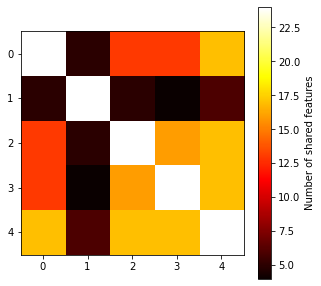

In [49]:
#Consistency of correlation feature selection
k=5
intersect=np.empty(shape=(k, k), dtype='float')

for i in range(0,k): # compare each fold to each other fold
    for j in range(0,k):
        intersect[i,j]=np.shape(np.intersect1d(comps[i], comps[j]))[0]

print(intersect)
plt.figure(figsize=(5,5))

plt.imshow(intersect, cmap='hot', interpolation='nearest')
cbar = plt.colorbar()
cbar.set_label('Number of shared features')
plt.title('Similarity of features between folds', fontsize=20)

plt.scatter(row,col,color='k')
plt.savefig(results_dir+string+ '.png')
plt.show()

Final size of X: (101, 86)


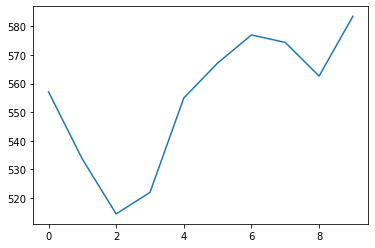

In [116]:
# partial least squares regression
from sklearn.cross_decomposition import PLSRegression
import hoggorm as ho
from scipy.stats import zscore

# cross-validation to find the number of components
components=np.linspace(1,10,10,dtype=int)

train_size=0.8
k=5

#X=np.concatenate([sc, fc], axis=1)
X=fc_n
X=prepare_data(X)

#set y to be the measure you want to predict
#Y = np.log(np.array(tmt))
Y=np.array(scores7)
Y=zscore(Y)

allvar=[]

outer_cv = KFold(n_splits=k, shuffle=True, random_state=p)

explvar=[]
for train, test in outer_cv.split(X):
    press=gridsearch_plsr(k, X[train], Y[train], components)
    
plt.plot(press)


15


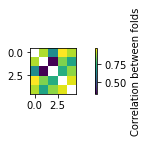

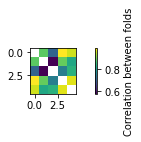

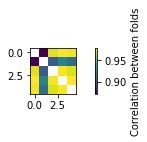

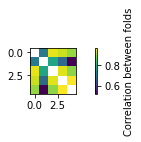

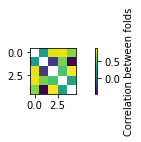

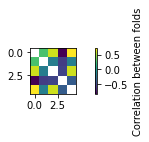

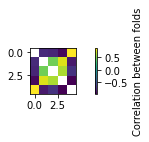

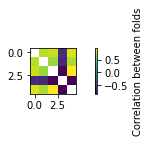

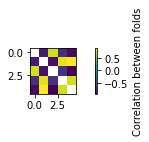

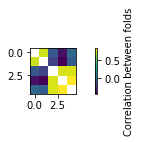

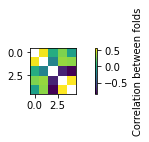

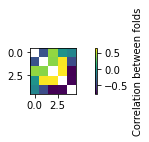

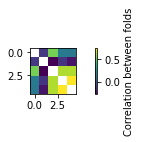

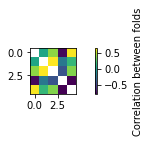

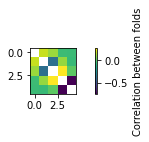

<BarContainer object of 15 artists>

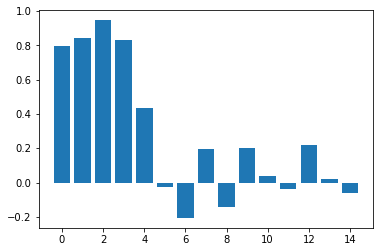

In [96]:
#Consistency of PCA feature selection

print(bestfeats)

correl=np.empty(shape=(k, k), dtype='float')
correlationp=[]
for p in range(0, bestfeats):
    for i in range(0,k): # compare each fold to each other fold
        for j in range(0,k):
            if i==j:
                correl[i,j]=np.nan
            else:
                #correlation between fold i and j for feature # p
                correl[i,j]=np.corrcoef(comps[i][p], comps[j][p])[1,0]
                #intersect[i, j]=np.intersect1d(comps[i], comps[j])
    plt.figure(figsize=(15,15))

    plt.subplot(bestfeats,2, p+1)
    plt.imshow(correl)
    cbar = plt.colorbar()
    cbar.set_label('Correlation between folds')
    plt.show()

    correlationp.append(np.nanmean(np.nanmean(correl)))
            


plt.bar(range(0, bestfeats), correlationp)
